In [1]:
import os
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.multiprocessing import Process
import cProfile
from functools import reduce
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re

In [32]:
from platform import python_version
print(python_version())
np.random.seed(5)

3.7.4


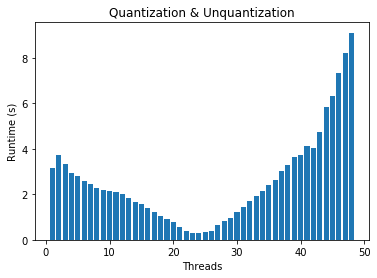

In [33]:
# Data from cluster, threads vs runtime for ext_par

text = '''1: 3.173571751220152
2: 3.7146062629763037
3: 3.3310687821358442
4: 2.9361960710957646
5: 2.7997454991564155
6: 2.5921663348563015
7: 2.457078356994316
8: 2.2834262119140476
9: 2.198558805976063
10: 2.128544044913724
11: 2.084765488980338
12: 1.9989492017775774
13: 1.8524344130419195
14: 1.6750469109974802
15: 1.564503428991884
16: 1.4099069060757756
17: 1.2209268889855593
18: 1.053470740094781
19: 0.9151992269326001
20: 0.7737897760234773
21: 0.5461187690962106
22: 0.3767246638890356
23: 0.3011473538354039
24: 0.28745930292643607
25: 0.33554783603176475
26: 0.38426492316648364
27: 0.648280501132831
28: 0.8134035069961101
29: 0.9749769191257656
30: 1.2165590629447252
31: 1.4438876449130476
32: 1.7012181831523776
33: 1.9101360149215907
34: 2.1601068191230297
35: 2.4012586208991706
36: 2.6313641630113125
37: 3.045009810011834
38: 3.2909150270279497
39: 3.6509759980253875
40: 3.740722575923428
41: 4.1134156819898635
42: 4.016981997992843
43: 4.719651118852198
44: 5.838739124825224
45: 6.302002134965733
46: 7.339802268892527
47: 8.218908707145602
48: 9.105605012970045'''

x = list(map(lambda x: int(x.split(': ')[0]), text.split('\n')))

y = list(map(lambda x: float(x.split(': ')[1]), text.split('\n')))

plt.title('Quantization & Unquantization')
plt.xlabel('Threads')
plt.ylabel('Runtime (s)')
_ = plt.bar(x,y)
plt.savefig('threadsVsRuntime.png')

In [34]:
numberOfSamples = 1000
numberOfFeatures = 1

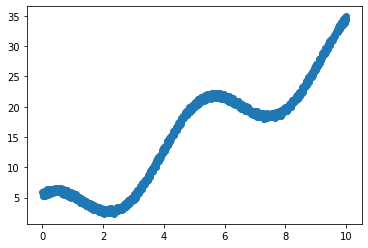

In [35]:
x = np.linspace(0, 10, numberOfSamples).reshape(-1, 1) # we want samples between 1 and -1
x = torch.from_numpy(x).float()
y = x * 3 + torch.rand(numberOfSamples).reshape(-1, 1) * 1 + 5* torch.cos(1.2*x)
plt.scatter(x, y)
#Axes3D.scatter(x.numpy(), x.numpy(), y.numpy())

In [36]:
# Define the model
def model(x, w, b):
    return x @ w.t() + b

# MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

def batch_iter(y, tx, batch_size, num_batches=1):
    data_size = len(y)
    shuffle_indices = np.random.permutation(np.arange(data_size))
    shuffled_y = y[shuffle_indices]
    shuffled_tx = tx[shuffle_indices]
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

In [37]:
def plot_solution(w, b, label=None):
    plt.scatter(x, y, s=2)
    plt.scatter(x, x @ w.t().detach() + b.detach(), s=2, label=label)

epoch 0  loss= tensor(323.9412, grad_fn=<DivBackward0>)
epoch 1  loss= tensor(406.4674, grad_fn=<DivBackward0>)
epoch 2  loss= tensor(351.8854, grad_fn=<DivBackward0>)
epoch 3  loss= tensor(28.6580, grad_fn=<DivBackward0>)
epoch 4  loss= tensor(20.5160, grad_fn=<DivBackward0>)
epoch 5  loss= tensor(25.2950, grad_fn=<DivBackward0>)
epoch 6  loss= tensor(7.9315, grad_fn=<DivBackward0>)
epoch 7  loss= tensor(12.7015, grad_fn=<DivBackward0>)
epoch 8  loss= tensor(9.2469, grad_fn=<DivBackward0>)
epoch 9  loss= tensor(12.3860, grad_fn=<DivBackward0>)
epoch 10  loss= tensor(16.9478, grad_fn=<DivBackward0>)
epoch 11  loss= tensor(18.2105, grad_fn=<DivBackward0>)
epoch 12  loss= tensor(18.8288, grad_fn=<DivBackward0>)
epoch 13  loss= tensor(11.3623, grad_fn=<DivBackward0>)
epoch 14  loss= tensor(13.6692, grad_fn=<DivBackward0>)
epoch 15  loss= tensor(14.9116, grad_fn=<DivBackward0>)
epoch 16  loss= tensor(12.3766, grad_fn=<DivBackward0>)
epoch 17  loss= tensor(12.1124, grad_fn=<DivBackward0>)
e

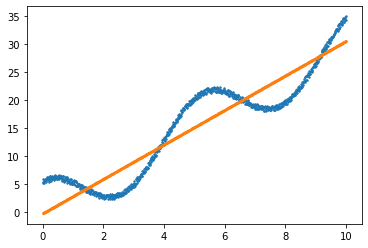

In [38]:
def sgd(targets, inputs, batch_size, max_iter, λ=5e-3):
    losses = []
    w = torch.randn(1, numberOfFeatures, requires_grad=True)
    b = torch.randn(numberOfFeatures, requires_grad=True)
    acc_loss = 0
    i = 0
    for ybatch, xbatch in batch_iter(targets, inputs, batch_size, max_iter):
        preds = model(xbatch, w, b)
        loss = mse(preds, ybatch)
        losses.append(loss)
        print('epoch', i, " loss=", loss)
        loss.backward()
        with torch.no_grad():
            w -= w.grad * λ
            b -= b.grad * λ
            w.grad.zero_()
            b.grad.zero_()
        i += 1
    return w, b, losses

if __name__ == '__main__':

    w, b, losses = sgd(y, x, 5, 100)
    plot_solution(w, b)
    print(str(w) + str(b))

In [39]:
def quantize(tensor):
    N = list(tensor.size())[0]
    Q = torch.zeros(N, dtype=bool)
    Q = tensor > 0
    return Q
def unquantize(tensor):
    tensor = tensor.type(torch.FloatTensor)
    tensor[tensor == 0] = -1
    return tensor # * data_scale

"""
GPU i is responsible for chunk i
"""
def ms_allreduce(tensor, chunksize=1):
    r = dist.get_rank()
    arraySize=tensor.size()
    acc = torch.zeros(arraySize)
    acc[r*chunksize:(r+1)*chunksize] = tensor[r*chunksize:(r+1)*chunksize]
    reqs = []
    #"Naive all-reduce"
    for i in range(dist.get_world_size()): # K steps
        if i != r:
            reqs += [dist.isend(tensor=quantize(tensor[i*chunksize:(i+1)*chunksize]), dst=i)] # K concurrent transfers
    for i in range(dist.get_world_size()): # K steps
        if i != r:
            recv = torch.zeros(arraySize, dtype=bool)
            dist.recv(tensor=recv[r*chunksize:(r+1)*chunksize],src=i) # K / ??? values...
            acc += unquantize(recv)
    for req in reqs:
        req.wait()
    reqs = []
    #"Naive all-gather"
    for i in range(dist.get_world_size()):
        if i != r:
            reqs += [dist.isend(tensor=quantize(acc[r*chunksize:(r+1)*chunksize]),dst=i)]
    #"Naive all-gather"
    for i in range(dist.get_world_size()):
        if i != r:
            recv = torch.zeros(arraySize, dtype=bool)
            dist.recv(tensor=recv[i*chunksize:(i+1)*chunksize], src=i)
            acc[i*chunksize:(i+1)*chunksize] += unquantize(recv[i*chunksize:(i+1)*chunksize])
    for req in reqs:
        req.wait()
    tensor[:] = acc[:]

In [40]:
def dist_sgdq(rank, size, group, targets, inputs, batch_size, max_iter, λ=1e-2, loss_tensor=None):
    losses = []
    w = torch.randn(1, numberOfFeatures, requires_grad=True)
    b = torch.randn(numberOfFeatures, requires_grad=True)
    acc_loss = 0
    i = 0
    for ybatch, xbatch in batch_iter(targets, inputs, batch_size, max_iter):
        preds = model(xbatch, w, b)
        loss = mse(preds, ybatch)
        if type(loss_tensor) != type(None):
            loss_tensor[i] = loss.item()
        #print('epoch(rank[', rank,'])', i, " loss=", loss)
        loss.backward()
        error_G = torch.zeros(w.size())
        error_b = torch.zeros(b.size())
        with torch.no_grad():
            G = w.grad.clone() + error_G
            ms_allreduce(w.grad)
            error_G = G - w.grad / size
            B = b.grad.clone() + error_b
            ms_allreduce(b.grad)
            error_b = B - b.grad / size 
            #print(rank, ': ', error, ' = ', G)
            #print('rank[', rank, '] has ', w.grad)
            w -= G * λ
            b -= B * λ
            w.grad.zero_()
            b.grad.zero_()
        i += 1
    return w, b

In [41]:
def init_processes(rank, size, fn, tl, backend='gloo'):
    """ Initialize the distributed environment. """
    os.environ['MASTER_ADDR'] = '127.0.0.1'
    os.environ['MASTER_PORT'] = '29500'
    dist.init_process_group(backend, rank=rank, world_size=size)
    fn(rank, size, tl)
    
def run(rank, size, tl):
    print(rank, 'running...')
    group = dist.new_group(list(range(size)))
    assert numberOfSamples % size == 0
    C = int(numberOfSamples / size)
    f, t = rank*C, (rank+1)*C
    if tl == None:
        loss_t = None
    else:
        loss_t = tl[rank*2 +1]
    w, b = dist_sgdq(rank, size, group, y[f:t], x[f:t], 5, 100, loss_tensor=loss_t) #should avg instead?
    #print('Solution rank', rank,{'w': w, 'b': b})
    tl[rank*2][0] = w.item()
    tl[rank*2][1] = b.item()
    #dist.send(tensor=w, dst=)

size = 2
processes = []

if __name__ == '__main__':
    
    np.random.seed(5)
    
    tl = [torch.tensor([0.0, 0.0]), torch.ones(100), torch.tensor([0.0, 0.0]), torch.ones(100)]
    
    for t in tl:
        t.share_memory_()
    
    for rank in range(size):
        p = Process(target=init_processes, args=(rank, size, run, tl))
        p.start()
        processes.append(p)

    #os.environ['MASTER_ADDR'] = '127.0.0.1'
    #os.environ['MASTER_PORT'] = '29500'
    #dist.init_process_group('gloo', rank=size, world_size=size+1)
    print(processes)

    for p in processes:
        p.join()
        
    p1_res = tl[0]
    p1_losses = tl[1]
    p2_res = tl[2]
    p2_losses = tl[3]
    print(p1_res)
    print(p2_res)

0 running...
1 running...
[<Process(Process-23, started)>, <Process(Process-24, started)>]
tensor([3.0468, 0.5449])
tensor([3.0738, 0.0470])


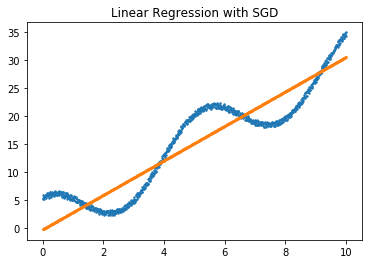

In [42]:
plt.title('Linear Regression with SGD')
plot_solution(w,b)
plt.tight_layout()
plt.savefig('plots/linReg_sgd.png')

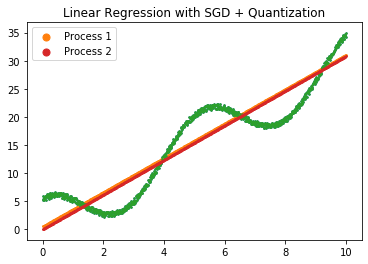

In [43]:
plt.title('Linear Regression with SGD + Quantization')
plot_solution(p1_res[0].view(1), p1_res[1].view(1), label='Process 1')
plot_solution(p2_res[0].view(1), p2_res[1].view(1), label='Process 2')
plt.legend(markerscale=5.0)
plt.tight_layout()
plt.savefig('plots/linReg_sgd_Q.png')

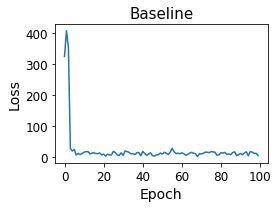

In [67]:
plt.figure(figsize=(4,3))
plt.title('Baseline', fontsize=15)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.plot(range(100), losses)
plt.savefig('plots/learningCurve_sgd.png')


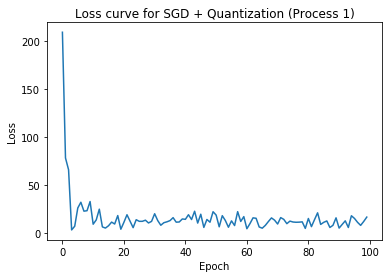

In [45]:
plt.title('Loss curve for SGD + Quantization (Process 1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(100), p1_losses.numpy())
plt.tight_layout()
plt.savefig('plots/learningCurve_sgd_q1.png')

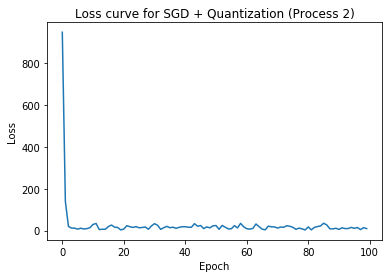

In [46]:
plt.title('Loss curve for SGD + Quantization (Process 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(100), p2_losses.numpy())
plt.tight_layout()
plt.savefig('plots/learningCurve_sgd_q2.png')

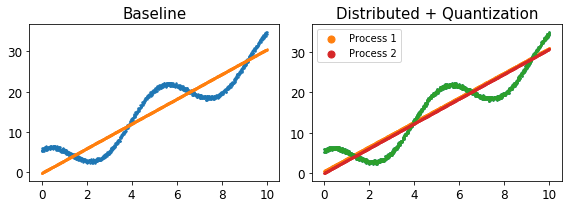

In [68]:
fig, axes = plt.subplots(1,2, figsize=(8,3))

ax = axes[0]
plt.sca(ax)
plt.title('Baseline', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plot_solution(w,b)

ax = axes[1]
plt.sca(ax)
plt.title('Distributed + Quantization', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plot_solution(p1_res[0].view(1), p1_res[1].view(1), label='Process 1')
plot_solution(p2_res[0].view(1), p2_res[1].view(1), label='Process 2')
plt.legend(markerscale=5.0)

plt.tight_layout()

plt.savefig('plots/linReg_sgd_both')

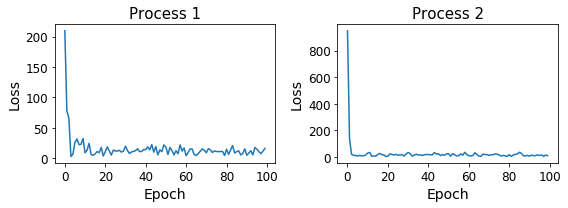

In [69]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
ax = axes[0]
plt.sca(ax)
plt.title('Process 1', fontsize=15)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(range(100), p1_losses.numpy())

ax = axes[1]
plt.sca(ax)
plt.title('Process 2', fontsize=15)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(range(100), p2_losses.numpy())


plt.tight_layout()

plt.savefig('plots/learningCurve_sgd_q_both.png')